# GitHub Issues EDA
## Impact of Issue Report Quality on Resolution Time

This notebook leverages an adaptation of the original dataset [found on Kaggle](https://www.kaggle.com/datasets/tobiasbueck/helpdesk-github-tickets/data).

### Abstract
When users submit issues on GitHub, they may be curious how quickly a resolution is estimated to arrive. Often, resolution times may be impacted by the quality of an issue report. This research aims to extract a rich understanding of the most impactful features to leverage for broad user guidance, train a high performing regression model capable of estimating resolution time within a useful threshold, and provide users with suggestions for improving the quality of their report.

### Approach
1. Extract resolution time, drop 'created_at' to remove data that won't be available at the time of prediction in the final product.
2. Feature engineering:
    - Time related features such as created_day, created_hour, etc.
    - Basic text features targeting common keywords and assigning an urgency score
    - TF-IDF and BERT features to extract syntactical patterns and semantics
3. Identify the best regression model and tune hyperparameters accordingly.
4. Train and test a regression model with the hyperparameter selection.
5. Build a mock UI for issue reporting, and implement prediction upon submission.


### Import and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Date/time processing
from datetime import datetime, timedelta
import dateutil.parser as parser

# Text processing
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Feature engineering
import os
os.environ['DISABLE_CODECARBON'] = '1'
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Model pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
github_df = pd.read_csv('github_issues.csv')

### Preview data

In [ ]:
print(f"Shape: {github_df.shape}")
print(f"Columns: {len(github_df.columns)}")
github_df.head(5)

Shape: (15955, 16)
Columns: 16


,created_at,closed_at,repo_name,title,body,labels_0_name,labels_10_name,labels_1_name,labels_2_name,labels_3_name,labels_4_name,labels_5_name,labels_6_name,labels_7_name,labels_8_name,labels_9_name
0,2023-05-05T15:54:28Z,2023-05-19T08:06:42Z,angular/angular,Article mistake,### Describe the problem that you experienced\n\nI think there is a samll mistake in the tutoria...,help wanted,NaN,good first issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-07T20:52:24Z,2024-07-10T07:06:59Z,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug\n\nIf you set ExtendsContentIntoTitleBar to true you'll still be able to ch...,bug,NaN,team-CompInput,area-TitleBar,Regression,area-Windowing,closed-Fixed,fix-released,NaN,NaN,NaN
2,2018-07-20T15:15:16Z,2022-11-01T03:42:28Z,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7\r\n\r\n**Steps to Reproduce**:\r\n\r\n1. Move caret to `this` and pres...,Bug,NaN,help wanted,Area-IDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-09-09T19:47:02Z,2019-09-13T21:42:29Z,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7\r\n\r\nIt appends the line which should register the loader and also cr...,bug,NaN,help wanted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-08T05:11:40Z,2022-07-11T16:10:58Z,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version\r\n\r\n2.18.0\r\n\r\n### Devices that reproduce the issue\r\n\r\nAny Andro...,bug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Types and Missing Values

In [6]:
info_df = pd.DataFrame({
    'Column': github_df.columns,
    'Data_Type': github_df.dtypes,
    'Non_Null_Count': github_df.count(),
    'Null_Count': github_df.isnull().sum(),
    'Null_Percentage': (github_df.isnull().sum() / len(github_df) * 100).round(2)
})
print(info_df.to_string(index=False))

        Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage
    created_at    object           15955           0             0.00
     closed_at    object           15955           0             0.00
     repo_name    object           15955           0             0.00
         title    object           15955           0             0.00
          body    object           15955           0             0.00
 labels_0_name    object           15946           9             0.06
labels_10_name    object               4       15951            99.97
 labels_1_name    object            8438        7517            47.11
 labels_2_name    object            3783       12172            76.29
 labels_3_name    object            1546       14409            90.31
 labels_4_name    object             662       15293            95.85
 labels_5_name    object             301       15654            98.11
 labels_6_name    object             144       15811            99.10
 labels_7_name    ob

### Cleaning

In [95]:
# Create a new copy
df = github_df.copy()

### Convert date columns to datetime

In [96]:
date_columns = ['created_at', 'closed_at']
answer_date_cols = [col for col in df.columns if 'answers_' in col and 'creation_time' in col]
date_columns.extend(answer_date_cols)

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

### Clean text

In [97]:
def clean_text(text):
    """Clean text by removing extra whitespace and handling NaN"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Replace common escape characters
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\r', ' ')
    return text

text_columns = [
    'title', 
    'body', 
    'repo_name', 
    'labels_0_name', 
    'labels_1_name', 
    'labels_2_name', 
    'labels_3_name', 
    'labels_4_name', 
    'labels_5_name', 
    'labels_6_name', 
    'labels_7_name', 
    'labels_8_name'
    ]

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

## Feature Engineering

### Extract labels

In [98]:
def extract_labels(issue):
    """Extract all non-null labels, replacing NaN with empty strings"""
    labels = []
    for i in range(11):  # labels_0 to labels_10
        label_col = f'labels_{i}_name'
        name = issue.get(label_col, '')
        # Replace NaN with empty string
        name = '' if pd.isna(name) else name
        if name:  # only include labels that have a name
            labels.append(name.lower())

    return labels

# Apply label extraction
df['labels'] = df.apply(extract_labels, axis=1)
df['n_labels'] = df['labels'].apply(len)

# Drop source columns
df = df.drop(columns=[col for col in df.columns if col.startswith('labels_')])

df.head(5)

,created_at,closed_at,repo_name,title,body,labels,n_labels
0,2023-05-05 15:54:28+00:00,2023-05-19 08:06:42+00:00,angular/angular,Article mistake,### Describe the problem that you experienced I think there is a samll mistake in the tutorial i...,"[help wanted, good first issue]",2
1,2024-06-07 20:52:24+00:00,2024-07-10 07:06:59+00:00,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug If you set ExtendsContentIntoTitleBar to true you'll still be able to chang...,"[bug, team-compinput, area-titlebar, regression, area-windowing, closed-fixed, fix-released]",7
2,2018-07-20 15:15:16+00:00,2022-11-01 03:42:28+00:00,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7 **Steps to Reproduce**: 1. Move caret to `this` and press `Ctrl+.` ```...,"[bug, help wanted, area-ide]",3
3,2019-09-09 19:47:02+00:00,2019-09-13 21:42:29+00:00,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7 It appends the line which should register the loader and also creates t...,"[bug, help wanted]",2
4,2022-07-08 05:11:40+00:00,2022-07-11 16:10:58+00:00,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version 2.18.0 ### Devices that reproduce the issue Any Android TV ### Devices tha...,[bug],1


### Binary features for common label categories

In [99]:
# Define label categories
bug_labels = ['bug', 'error', 'issue', 'problem', 'broken', 'crash', 'defect']
feature_labels = ['feature', 'enhancement', 'request', 'improvement', 'new']
doc_labels = ['documentation', 'docs', 'readme', 'guide', 'tutorial']
help_labels = ['help', 'question', 'support', 'how-to']
priority_labels = ['urgent', 'critical', 'high', 'medium', 'low', 'p1', 'p2', 'p3']
status_labels = ['in-progress', 'blocked', 'waiting', 'ready', 'done', 'fixed']

# Create binary features
def has_label_category(labels, category_words):
    return int(any(any(word in label.lower() for word in category_words) for label in labels))

df['is_bug_cat'] = df['labels'].apply(lambda x: has_label_category(x, bug_labels))
df['is_feature_cat'] = df['labels'].apply(lambda x: has_label_category(x, feature_labels))
df['is_doc_cat'] = df['labels'].apply(lambda x: has_label_category(x, doc_labels))
df['is_help_cat'] = df['labels'].apply(lambda x: has_label_category(x, help_labels))
df['is_priority_cat'] = df['labels'].apply(lambda x: has_label_category(x, priority_labels))
df['is_status_cat'] = df['labels'].apply(lambda x: has_label_category(x, status_labels))

df.head(5)

,created_at,closed_at,repo_name,title,body,labels,n_labels,is_bug_cat,is_feature_cat,is_doc_cat,is_help_cat,is_priority_cat,is_status_cat
0,2023-05-05 15:54:28+00:00,2023-05-19 08:06:42+00:00,angular/angular,Article mistake,### Describe the problem that you experienced I think there is a samll mistake in the tutorial i...,"[help wanted, good first issue]",2,1,0,0,1,0,0
1,2024-06-07 20:52:24+00:00,2024-07-10 07:06:59+00:00,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug If you set ExtendsContentIntoTitleBar to true you'll still be able to chang...,"[bug, team-compinput, area-titlebar, regression, area-windowing, closed-fixed, fix-released]",7,1,0,0,0,0,1
2,2018-07-20 15:15:16+00:00,2022-11-01 03:42:28+00:00,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7 **Steps to Reproduce**: 1. Move caret to `this` and press `Ctrl+.` ```...,"[bug, help wanted, area-ide]",3,1,0,0,1,0,0
3,2019-09-09 19:47:02+00:00,2019-09-13 21:42:29+00:00,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7 It appends the line which should register the loader and also creates t...,"[bug, help wanted]",2,1,0,0,1,0,0
4,2022-07-08 05:11:40+00:00,2022-07-11 16:10:58+00:00,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version 2.18.0 ### Devices that reproduce the issue Any Android TV ### Devices tha...,[bug],1,1,0,0,0,0,0


### Binary features for top 25 issue labels

In [100]:
# Extract top 25 labels and create binary features (with case normalization)
print("🔍 Analyzing labels column to find top 25 most frequent labels...")

# Flatten all labels from the lists and count occurrences (normalize to lowercase)
all_labels = []
for label_list in df['labels']:
    if isinstance(label_list, list):
        # Convert all labels to lowercase to normalize casing
        normalized_labels = [label.lower() for label in label_list]
        all_labels.extend(normalized_labels)

# Count label frequencies (now case-insensitive)
from collections import Counter
label_counts = Counter(all_labels)

# Get top 25 most frequent labels
top_25_labels = label_counts.most_common(25)

print(f"\n📊 Top 25 Labels by Frequency (Case-Normalized):")
print("=" * 60)

for i, (label, count) in enumerate(top_25_labels, 1):
    percentage = (count / len(all_labels)) * 100
    print(f"{i:2d}. {label:<35} | Count: {count:>5,} | {percentage:>5.1f}%")

print(f"\nTotal unique labels found: {len(label_counts)}")
print(f"Total label occurrences: {len(all_labels):,}")

# Create binary features for top 25 labels
print(f"\n🔧 Creating binary features for top 25 labels...")

for label, count in top_25_labels:
    # Create safe column name (replace spaces, special chars with underscores)
    safe_name = label.replace(' ', '_').replace(':', '_').replace('-', '_').replace('/', '_').replace('(', '').replace(')', '').replace('.', '').replace(',', '')
    
    # Create binary feature (check for case-insensitive match)
    col_name = f"has_{safe_name}_label"
    df[col_name] = df['labels'].apply(lambda x: int(any(label.lower() == l.lower() for l in x)) if isinstance(x, list) else 0)
    
    # Print progress
    print(f"  ✓ Created: {col_name}")

# Verify the new features
print(f"\n✅ Verification:")
print(f"  • Original columns: {len(df.columns) - 25}")
print(f"  • New label features: 25")
print(f"  • Total columns: {len(df.columns)}")

# Show sample of new features
label_feature_cols = [col for col in df.columns if col.startswith('has_') and col.endswith('_label')]
print(f"\n📋 New label feature columns:")
for col in label_feature_cols[:10]:  # Show first 10
    count = df[col].sum()
    print(f"  • {col}: {count:,} issues ({count/len(df)*100:.1f}%)")

if len(label_feature_cols) > 10:
    print(f"  • ... and {len(label_feature_cols) - 10} more")

# Optional: Show correlation with resolution time if it exists
if 'n_days_to_resolution' in df.columns:
    print(f"\n🔗 Correlation with resolution time:")
    correlations = []
    for col in label_feature_cols:
        corr = df[col].corr(df['n_days_to_resolution'])
        correlations.append((col, corr))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top 10 label features by correlation with resolution time:")
    for col, corr in correlations[:10]:
        direction = "increases" if corr > 0 else "decreases"
        print(f"  • {col}: {corr:.3f} ({direction} resolution time)")

df.drop(columns=[col for col in df.columns if col == 'labels' or (col.startswith('labels_') and col.endswith('_name'))], inplace=True, errors='ignore')



🔍 Analyzing labels column to find top 25 most frequent labels...

📊 Top 25 Labels by Frequency (Case-Normalized):
 1. bug                                 | Count: 13,269 |  42.8%
 2. good first issue                    | Count: 1,480 |   4.8%
 3. help wanted                         | Count:   671 |   2.2%
 4. enhancement                         | Count:   636 |   2.1%
 5. documentation                       | Count:   592 |   1.9%
 6. stale                               | Count:   290 |   0.9%
 7. waiting for customer response       | Count:   152 |   0.5%
 8. regression                          | Count:   134 |   0.4%
 9. question                            | Count:   129 |   0.4%
10. needs triage                        | Count:   122 |   0.4%
11. issue: confirmed                    | Count:   115 |   0.4%
12. needs-triage                        | Count:   114 |   0.4%
13. type: bug                           | Count:   111 |   0.4%
14. fixed                               | Count:   10

### Visualize label distribution

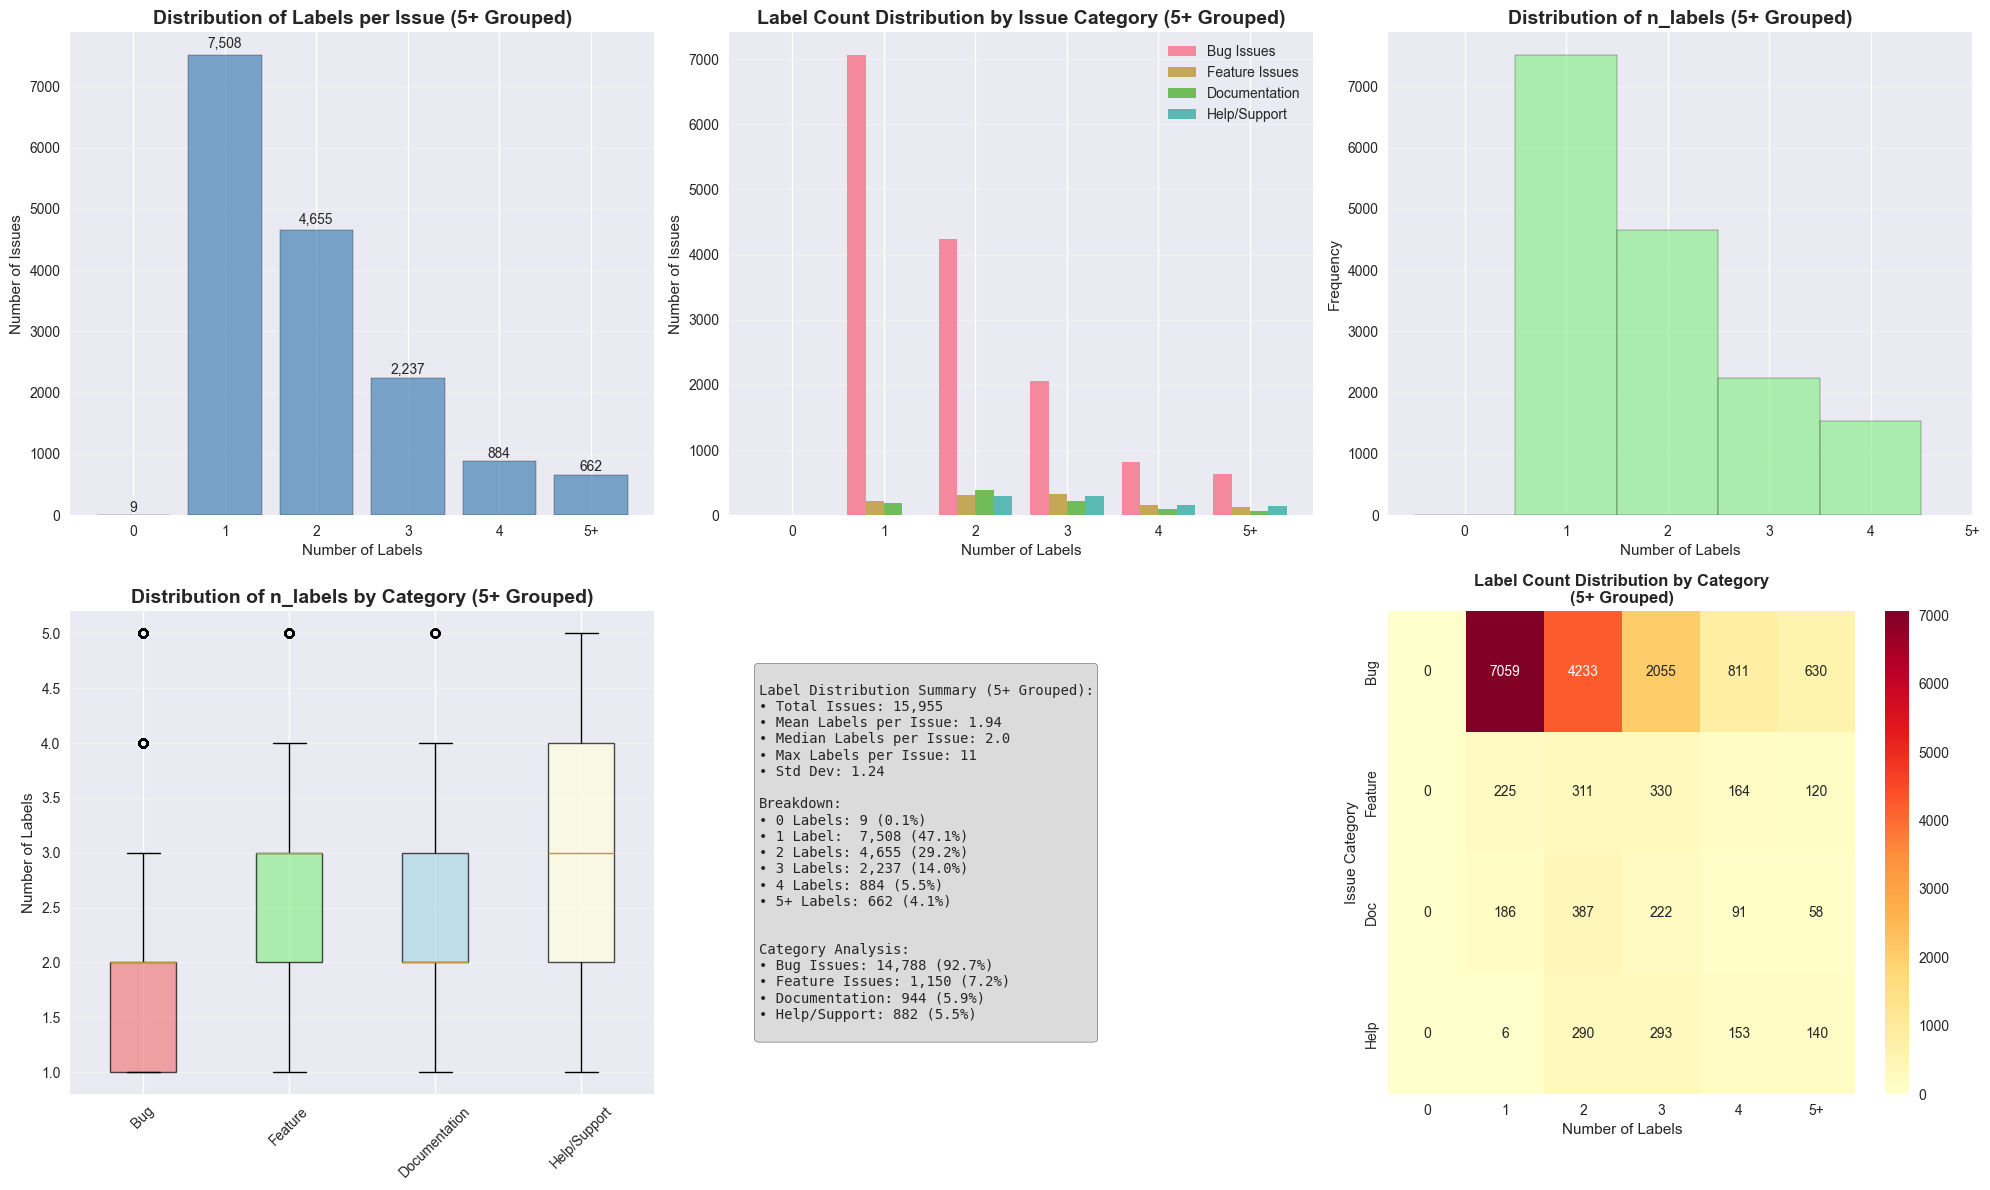


🔍 Detailed Category Analysis (5+ Grouped):

Bug Issues:
  • Count: 14,788 (92.7% of total)
  • Avg Labels: 1.94
  • Median Labels: 2.0
  • Std Dev: 1.25
  • Label Distribution (5+ grouped): {1: np.int64(7059), 2: np.int64(4233), 3: np.int64(2055), 4: np.int64(811), 5: np.int64(630)}

Feature Issues:
  • Count: 1,150 (7.2% of total)
  • Avg Labels: 2.74
  • Median Labels: 3.0
  • Std Dev: 1.36
  • Label Distribution (5+ grouped): {1: np.int64(225), 2: np.int64(311), 3: np.int64(330), 4: np.int64(164), 5: np.int64(120)}

Documentation Issues:
  • Count: 944 (5.9% of total)
  • Avg Labels: 2.45
  • Median Labels: 2.0
  • Std Dev: 1.18
  • Label Distribution (5+ grouped): {1: np.int64(186), 2: np.int64(387), 3: np.int64(222), 4: np.int64(91), 5: np.int64(58)}

Help/Support Issues:
  • Count: 882 (5.5% of total)
  • Avg Labels: 3.28
  • Median Labels: 3.0
  • Std Dev: 1.40
  • Label Distribution (5+ grouped): {1: np.int64(6), 2: np.int64(290), 3: np.int64(293), 4: np.int64(153), 5: np.int6

,created_at,closed_at,repo_name,title,body,n_labels,is_bug_cat,is_feature_cat,is_doc_cat,is_help_cat,is_priority_cat,is_status_cat,has_bug_label,has_good_first_issue_label,has_help_wanted_label,has_enhancement_label,has_documentation_label,has_stale_label,has_waiting_for_customer_response_label,has_regression_label,has_question_label,has_needs_triage_label,has_issue__confirmed_label,has_type__bug_label,has_fixed_label,has_topic_editor_label,has_docs_label,has_confirmed_label,has_in_triage_label,has_customer_reported_label,has_client_label,has_inactive_label,has_type_bug_label,has_p2_label,has_archived_label,has_backlog_label
0,2023-05-05 15:54:28+00:00,2023-05-19 08:06:42+00:00,angular/angular,Article mistake,### Describe the problem that you experienced I think there is a samll mistake in the tutorial i...,2,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2024-06-07 20:52:24+00:00,2024-07-10 07:06:59+00:00,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug If you set ExtendsContentIntoTitleBar to true you'll still be able to chang...,7,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-07-20 15:15:16+00:00,2022-11-01 03:42:28+00:00,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7 **Steps to Reproduce**: 1. Move caret to `this` and press `Ctrl+.` ```...,3,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-09-09 19:47:02+00:00,2019-09-13 21:42:29+00:00,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7 It appends the line which should register the loader and also creates t...,2,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-07-08 05:11:40+00:00,2022-07-11 16:10:58+00:00,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version 2.18.0 ### Devices that reproduce the issue Any Android TV ### Devices tha...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
plt.figure(figsize=(20, 12))

# 1. Distribution of label count (overall) - Updated with 5+ grouping
plt.subplot(2, 3, 1)
label_counts = df['n_labels'].value_counts().sort_index()

# Group 5+ labels together
small_counts = label_counts[label_counts.index >= 5]
large_counts = label_counts[label_counts.index < 5]

if len(small_counts) > 0:
    # Create grouped data
    grouped_data = large_counts.copy()
    grouped_data.loc[5] = small_counts.sum()  # Sum all 5+ labels
    
    bars = plt.bar(grouped_data.index, grouped_data.values, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title('Distribution of Labels per Issue (5+ Grouped)', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Issues')
    plt.xticks(range(6), ['0', '1', '2', '3', '4', '5+'])
else:
    bars = plt.bar(label_counts.index, label_counts.values, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title('Distribution of Labels per Issue', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Issues')

plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 2. Distribution of label count by category - Updated with 5+ grouping
plt.subplot(2, 3, 2)
# Create a grouped bar chart showing label count distribution for each category
categories = ['is_bug_cat', 'is_feature_cat', 'is_doc_cat', 'is_help_cat']
category_names = ['Bug Issues', 'Feature Issues', 'Documentation', 'Help/Support']

# Get data for each category with 5+ grouping
category_data = []
for cat in categories:
    if cat in df.columns:
        cat_counts = df[df[cat] == 1]['n_labels'].value_counts().sort_index()
        
        # Group 5+ labels for this category
        cat_small = cat_counts[cat_counts.index >= 5]
        cat_large = cat_counts[cat_counts.index < 5]
        
        if len(cat_small) > 0:
            grouped_cat = cat_large.copy()
            grouped_cat.loc[5] = cat_small.sum()
            category_data.append(grouped_cat)
        else:
            category_data.append(cat_counts)

# Create grouped bar chart
x = np.arange(6)  # 0, 1, 2, 3, 4, 5+
width = 0.2

for i, (cat_data, cat_name) in enumerate(zip(category_data, category_names)):
    # Ensure we have data for all 6 positions (0-4, 5+)
    values = [cat_data.get(idx, 0) for idx in range(6)]
    bars = plt.bar(x + i*width, values, width, label=cat_name, alpha=0.8)

plt.xlabel('Number of Labels')
plt.ylabel('Number of Issues')
plt.title('Label Count Distribution by Issue Category (5+ Grouped)', fontsize=14, fontweight='bold')
plt.xticks(x + width*1.5, ['0', '1', '2', '3', '4', '5+'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 3. Distribution of n_labels (detailed view) - Updated with 5+ grouping
plt.subplot(2, 3, 3)
# Create histogram with 5+ grouping
n_labels_grouped = df['n_labels'].copy()
n_labels_grouped[n_labels_grouped >= 5] = 5  # Group 5+ as 5

plt.hist(n_labels_grouped, bins=range(0, 6), alpha=0.7, 
         color='lightgreen', edgecolor='black', align='left')
plt.title('Distribution of n_labels (5+ Grouped)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(6), ['0', '1', '2', '3', '4', '5+'])

# 4. Distribution of n_labels by category - Updated with 5+ grouping
plt.subplot(2, 3, 4)
if 'has_bug_label' in df.columns:
    categories = ['is_bug_cat', 'is_feature_cat', 'is_doc_cat', 'is_help_cat']
    category_names = ['Bug', 'Feature', 'Documentation', 'Help/Support']
    
    # Create box plots for each category with 5+ grouping
    category_data = []
    for cat in categories:
        if cat in df.columns:
            cat_n_labels = df[df[cat] == 1]['n_labels'].copy()
            cat_n_labels[cat_n_labels >= 5] = 5  # Group 5+ as 5
            category_data.append(cat_n_labels.values)
    
    box_plot = plt.boxplot(category_data, labels=category_names, patch_artist=True)
    
    # Color the boxes
    colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightyellow']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.title('Distribution of n_labels by Category (5+ Grouped)', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Labels')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)

# 5. Summary statistics - Updated with 5+ grouping
plt.subplot(2, 3, 5)
plt.axis('off')

# Basic stats with 5+ grouping
basic_stats = f"""
Label Distribution Summary (5+ Grouped):
• Total Issues: {len(df):,}
• Mean Labels per Issue: {df['n_labels'].mean():.2f}
• Median Labels per Issue: {df['n_labels'].median():.1f}
• Max Labels per Issue: {df['n_labels'].max()}
• Std Dev: {df['n_labels'].std():.2f}

Breakdown:
• 0 Labels: {len(df[df['n_labels'] == 0]):,} ({(len(df[df['n_labels'] == 0])/len(df)*100):.1f}%)
• 1 Label:  {len(df[df['n_labels'] == 1]):,} ({(len(df[df['n_labels'] == 1])/len(df)*100):.1f}%)
• 2 Labels: {len(df[df['n_labels'] == 2]):,} ({(len(df[df['n_labels'] == 2])/len(df)*100):.1f}%)
• 3 Labels: {len(df[df['n_labels'] == 3]):,} ({(len(df[df['n_labels'] == 3])/len(df)*100):.1f}%)
• 4 Labels: {len(df[df['n_labels'] == 4]):,} ({(len(df[df['n_labels'] == 4])/len(df)*100):.1f}%)
• 5+ Labels: {len(df[df['n_labels'] >= 5]):,} ({(len(df[df['n_labels'] >= 5])/len(df)*100):.1f}%)
"""

# Category stats
if 'has_bug_label' in df.columns:
    category_stats = f"""

Category Analysis:
• Bug Issues: {len(df[df['is_bug_cat'] == 1]):,} ({(len(df[df['is_bug_cat'] == 1])/len(df)*100):.1f}%)
• Feature Issues: {len(df[df['is_feature_cat'] == 1]):,} ({(len(df[df['is_feature_cat'] == 1])/len(df)*100):.1f}%)
• Documentation: {len(df[df['is_doc_cat'] == 1]):,} ({(len(df[df['is_doc_cat'] == 1])/len(df)*100):.1f}%)
• Help/Support: {len(df[df['is_help_cat'] == 1]):,} ({(len(df[df['is_help_cat'] == 1])/len(df)*100):.1f}%)
"""
else:
    category_stats = "\n\nCategory Analysis:\n• Category features not yet created"

# Combine stats
full_stats = basic_stats + category_stats

plt.text(0.05, 0.5, full_stats, fontsize=10, fontfamily='monospace', 
         verticalalignment='center', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

# 6. Additional insight: Label count vs category heatmap - Updated with 5+ grouping
plt.subplot(2, 3, 6)
if 'has_bug_label' in df.columns:
    # Create a heatmap showing label count distribution by category (5+ grouped)
    categories = ['is_bug_cat', 'is_feature_cat', 'is_doc_cat', 'is_help_cat']
    category_names = ['Bug', 'Feature', 'Doc', 'Help']
    
    # Create matrix: rows = categories, columns = label counts (0-4, 5+)
    heatmap_data = np.zeros((len(categories), 6))  # 0, 1, 2, 3, 4, 5+
    
    for i, cat in enumerate(categories):
        if cat in df.columns:
            for j in range(6):
                if j < 5:
                    count = len(df[(df[cat] == 1) & (df['n_labels'] == j)])
                else:
                    count = len(df[(df[cat] == 1) & (df['n_labels'] >= 5)])
                heatmap_data[i, j] = count
    
    # Convert to integer type and handle any NaN values
    heatmap_data = heatmap_data.astype(int)
    
    # Create heatmap with proper formatting
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=['0', '1', '2', '3', '4', '5+'], yticklabels=category_names)
    plt.title('Label Count Distribution by Category\n(5+ Grouped)', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Labels')
    plt.ylabel('Issue Category')

plt.tight_layout()
plt.show()

# Print additional insights
print("\n🔍 Detailed Category Analysis (5+ Grouped):")
if 'has_bug_label' in df.columns:
    for cat, name in zip(['is_bug_cat', 'is_feature_cat', 'is_doc_cat', 'is_help_cat'], 
                         ['Bug Issues', 'Feature Issues', 'Documentation Issues', 'Help/Support Issues']):
        if cat in df.columns:
            cat_issues = df[df[cat] == 1]
            print(f"\n{name}:")
            print(f"  • Count: {len(cat_issues):,} ({(len(cat_issues)/len(df)*100):.1f}% of total)")
            print(f"  • Avg Labels: {cat_issues['n_labels'].mean():.2f}")
            print(f"  • Median Labels: {cat_issues['n_labels'].median():.1f}")
            print(f"  • Std Dev: {cat_issues['n_labels'].std():.2f}")
            
            # Show distribution with 5+ grouped
            grouped_dist = cat_issues['n_labels'].copy()
            grouped_dist[grouped_dist >= 5] = 5
            dist_counts = grouped_dist.value_counts().sort_index()
            print(f"  • Label Distribution (5+ grouped): {dict(dist_counts)}")
df.head(5)

### Time Features

In [102]:
# Create time features
df['created_hour'] = df['created_at'].dt.hour
df['created_day_of_week'] = df['created_at'].dt.dayofweek
df['created_month'] = df['created_at'].dt.month
df['n_days_to_resolution'] = round((df['closed_at'] - df['created_at']).dt.total_seconds() / (3600 * 24), 2)

# Drop source columns
df.drop(columns=['created_at', 'closed_at'], axis=1, inplace=True)
df.head(5)

,repo_name,title,body,n_labels,is_bug_cat,is_feature_cat,is_doc_cat,is_help_cat,is_priority_cat,is_status_cat,has_bug_label,has_good_first_issue_label,has_help_wanted_label,has_enhancement_label,has_documentation_label,has_stale_label,has_waiting_for_customer_response_label,has_regression_label,has_question_label,has_needs_triage_label,has_issue__confirmed_label,has_type__bug_label,has_fixed_label,has_topic_editor_label,has_docs_label,has_confirmed_label,has_in_triage_label,has_customer_reported_label,has_client_label,has_inactive_label,has_type_bug_label,has_p2_label,has_archived_label,has_backlog_label,created_hour,created_day_of_week,created_month,n_days_to_resolution
0,angular/angular,Article mistake,### Describe the problem that you experienced I think there is a samll mistake in the tutorial i...,2,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,4,5,13.68
1,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug If you set ExtendsContentIntoTitleBar to true you'll still be able to chang...,7,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,4,6,32.43
2,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7 **Steps to Reproduce**: 1. Move caret to `this` and press `Ctrl+.` ```...,3,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,4,7,1564.52
3,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7 It appends the line which should register the loader and also creates t...,2,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,9,4.08
4,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version 2.18.0 ### Devices that reproduce the issue Any Android TV ### Devices tha...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4,7,3.46


### Visualize issue submission time distribution

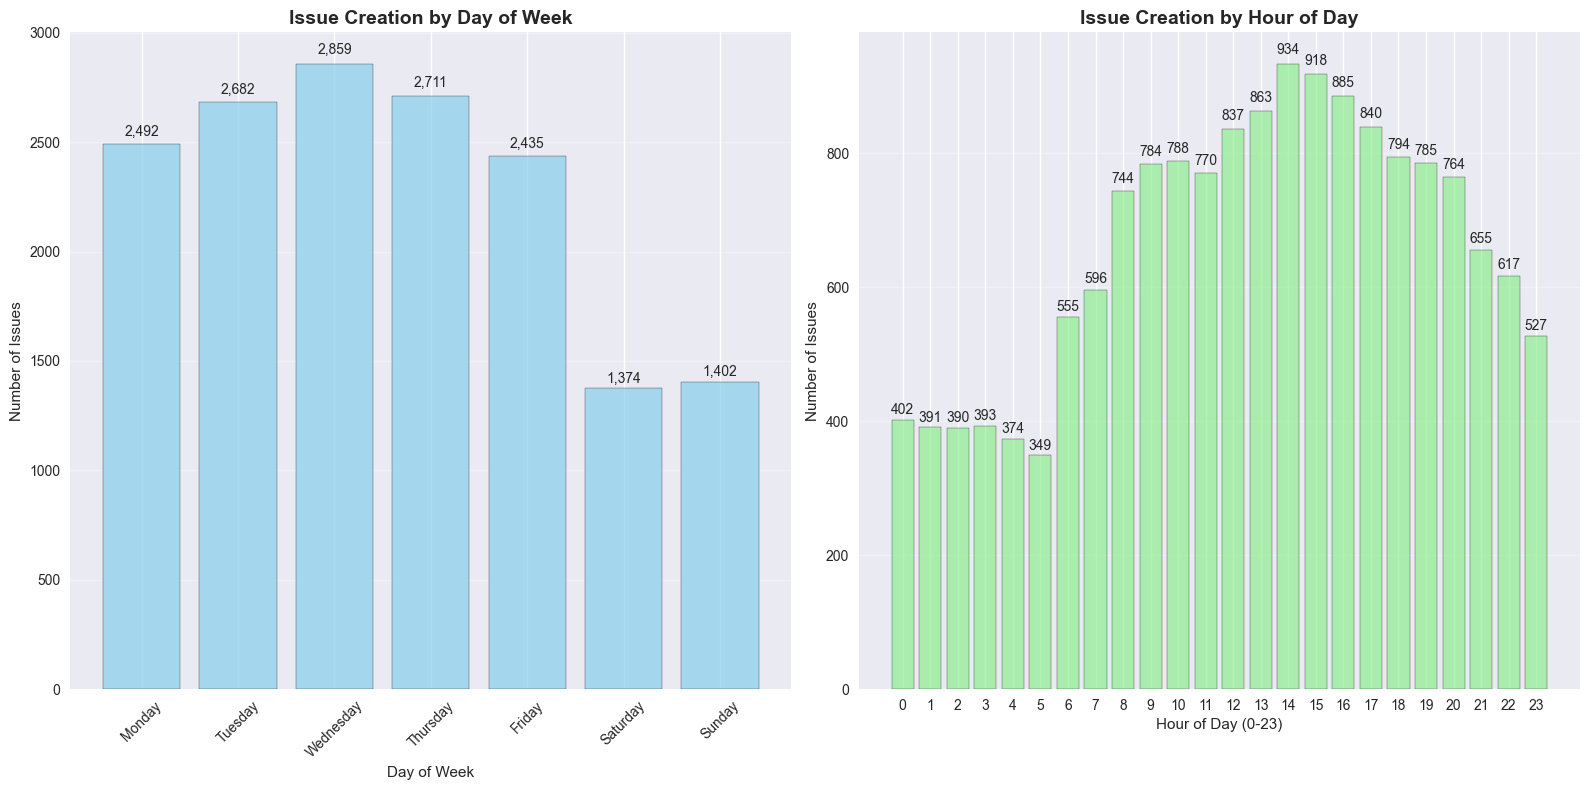


📅 Time Distribution Summary:

Day of Week Distribution:
  Monday    :  2,492 issues ( 15.6%)
  Tuesday   :  2,682 issues ( 16.8%)
  Wednesday :  2,859 issues ( 17.9%)
  Thursday  :  2,711 issues ( 17.0%)
  Friday    :  2,435 issues ( 15.3%)
  Saturday  :  1,374 issues (  8.6%)
  Sunday    :  1,402 issues (  8.8%)

Most active day: Wednesday (2,859 issues)
Least active day: Saturday (1,374 issues)

Hour of Day Distribution:
   0:00- 0:59:    402 issues (  2.5%)
   1:00- 1:59:    391 issues (  2.5%)
   2:00- 2:59:    390 issues (  2.4%)
   3:00- 3:59:    393 issues (  2.5%)
   4:00- 4:59:    374 issues (  2.3%)
   5:00- 5:59:    349 issues (  2.2%)
   6:00- 6:59:    555 issues (  3.5%)
   7:00- 7:59:    596 issues (  3.7%)
   8:00- 8:59:    744 issues (  4.7%)
   9:00- 9:59:    784 issues (  4.9%)
  10:00-10:59:    788 issues (  4.9%)
  11:00-11:59:    770 issues (  4.8%)
  12:00-12:59:    837 issues (  5.2%)
  13:00-13:59:    863 issues (  5.4%)
  14:00-14:59:    934 issues (  5.8%)
  

In [103]:
# Visualize time-based distributions
plt.figure(figsize=(16, 8))

# 1. Distribution of issues by day of week
plt.subplot(1, 2, 1)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['created_day_of_week'].value_counts().sort_index()

bars = plt.bar(range(7), day_counts.values, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Issue Creation by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Issues')
plt.xticks(range(7), day_names, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 2. Distribution of issues by hour of day
plt.subplot(1, 2, 2)
hour_counts = df['created_hour'].value_counts().sort_index()

bars = plt.bar(hour_counts.index, hour_counts.values, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Issue Creation by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Issues')
plt.xticks(range(0, 24, 1))
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📅 Time Distribution Summary:")
print("=" * 50)

print("\nDay of Week Distribution:")
day_percentages = (day_counts / len(df) * 100).round(2)
for i, (day, count) in enumerate(zip(day_names, day_counts.values)):
    print(f"  {day:<10}: {count:>6,} issues ({day_percentages.iloc[i]:>5.1f}%)")

print(f"\nMost active day: {day_names[day_counts.idxmax()]} ({day_counts.max():,} issues)")
print(f"Least active day: {day_names[day_counts.idxmin()]} ({day_counts.min():,} issues)")

print("\nHour of Day Distribution:")
hour_percentages = (hour_counts / len(df) * 100).round(2)
for hour in range(24):
    count = hour_counts.get(hour, 0)
    percentage = hour_percentages.get(hour, 0)
    print(f"  {hour:2d}:00-{hour:2d}:59: {count:>6,} issues ({percentage:>5.1f}%)")

print(f"\nMost active hour: {hour_counts.idxmax()}:00 ({hour_counts.max():,} issues)")
print(f"Least active hour: {hour_counts.idxmin()}:00 ({hour_counts.min():,} issues)")

# Additional insights
print(f"\n💡 Key Insights:")
print(f"  • Weekday vs Weekend: {day_counts.iloc[:5].sum():,} vs {day_counts.iloc[5:].sum():,} issues")
print(f"  • Business hours (9-17) vs Off-hours (18-8): {hour_counts.loc[9:17].sum():,} vs {hour_counts.loc[18:23].sum() + hour_counts.loc[0:8].sum():,} issues")
print(f"  • Peak activity: {day_names[day_counts.idxmax()]} at {hour_counts.idxmax()}:00")

### Basic Text Features

In [104]:
# Basic text features
df['title_length'] = df['title'].str.len()
df['body_length'] = df['body'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['body_word_count'] = df['body'].str.split().str.len()

# Code-related features
df['has_code_blocks'] = df['body'].str.contains('```', na=False).astype(int)
df['code_block_count'] = df['body'].str.count('```') // 2

# URL features
df['url_count'] = df['body'].str.count(r'https?://[^\s]+')
df['has_urls'] = (df['url_count'] > 0).astype(int)

# Question indicators - scanning both title and body
question_words = ['how', 'what', 'why', 'when', 'where', 'which', 'who']

# Title question indicators
df['title_question_word_count'] = df['title'].str.lower().str.count('|'.join(question_words))
df['title_has_question_mark'] = df['title'].str.contains('\?', na=False).astype(int)

# Body question indicators
df['body_question_word_count'] = df['body'].str.lower().str.count('|'.join(question_words))
df['body_has_question_mark'] = df['body'].str.contains('\?', na=False).astype(int)

# Combined question indicators
df['total_question_word_count'] = df['title_question_word_count'] + df['body_question_word_count']
df['total_has_question_mark'] = df['title_has_question_mark'] + df['body_has_question_mark']
df['includes_questions'] = ((df['total_question_word_count'] > 0) | (df['total_has_question_mark'] > 0)).astype(int)

# Urgency indicators - scanning both title and body
urgent_words = ['urgent', 'critical', 'asap', 'immediate', 'emergency', 'broken', 'error', 'serious', 'security']

# Title urgency indicators
df['title_n_urgent_words'] = df['title'].str.lower().str.count('|'.join(urgent_words))
df['title_has_exclamation'] = df['title'].str.contains('!', na=False).astype(int)

# Body urgency indicators
df['body_n_urgent_words'] = df['body'].str.lower().str.count('|'.join(urgent_words))
df['body_has_exclamation'] = df['body'].str.contains('!', na=False).astype(int)

# Combined urgency indicators
df['total_n_urgent_words'] = df['title_n_urgent_words'] + df['body_n_urgent_words']
df['total_has_exclamation'] = df['title_has_exclamation'] + df['body_has_exclamation']
df['urgency_score'] = df['total_n_urgent_words'] + df['total_has_exclamation']

In [106]:
df.head(5)

,repo_name,title,body,n_labels,is_bug_cat,is_feature_cat,is_doc_cat,is_help_cat,is_priority_cat,is_status_cat,has_bug_label,has_good_first_issue_label,has_help_wanted_label,has_enhancement_label,has_documentation_label,has_stale_label,has_waiting_for_customer_response_label,has_regression_label,has_question_label,has_needs_triage_label,has_issue__confirmed_label,has_type__bug_label,has_fixed_label,has_topic_editor_label,has_docs_label,has_confirmed_label,has_in_triage_label,has_customer_reported_label,has_client_label,has_inactive_label,has_type_bug_label,has_p2_label,has_archived_label,has_backlog_label,created_hour,created_day_of_week,created_month,n_days_to_resolution,title_length,body_length,title_word_count,body_word_count,has_code_blocks,code_block_count,url_count,has_urls,title_question_word_count,title_has_question_mark,body_question_word_count,body_has_question_mark,total_question_word_count,total_has_question_mark,includes_questions,title_n_urgent_words,title_has_exclamation,body_n_urgent_words,body_has_exclamation,total_n_urgent_words,total_has_exclamation,urgency_score
0,angular/angular,Article mistake,### Describe the problem that you experienced I think there is a samll mistake in the tutorial i...,2,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,4,5,13.68,15,1107,2,166,0,0,2,1,0,0,2,0,2,0,1,0,0,1,0,1,0,1
1,microsoft/microsoft-ui-xaml,Able to change the window height even if IsResizable is false but ExtendsContentIntoTitleBar is ...,### Describe the bug If you set ExtendsContentIntoTitleBar to true you'll still be able to chang...,7,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,4,6,32.43,100,618,15,94,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,dotnet/roslyn,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7 **Steps to Reproduce**: 1. Move caret to `this` and press `Ctrl+.` ```...,3,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,4,7,1564.52,45,511,8,88,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
3,rails/webpacker,bundle exec rails webpacker:install:typescript creates an invalid entry in config/webpack/enviro...,webpacker version: 4.0.7 It appends the line which should register the loader and also creates t...,2,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,9,4.08,104,268,10,25,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0
4,google/ExoPlayer,MediaSession play/pause events not propagated to LeanbackPlayerAdapter,### ExoPlayer Version 2.18.0 ### Devices that reproduce the issue Any Android TV ### Devices tha...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4,7,3.46,70,1464,7,175,1,1,1,1,0,0,4,1,4,1,1,0,0,0,0,0,0,0


### Encode repo_name

In [107]:
# Create label encoder
repo_encoder = LabelEncoder()
df['repo_encoded'] = repo_encoder.fit_transform(df['repo_name'])

# Drop source columns
df.drop(columns=['repo_name'], axis=1, inplace=True)

### Text Embeddings

combined_text = df[['title', 'body']].fillna('').apply(lambda x: ' '.join(x), axis=1)

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=250, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(combined_text)

tfidf_features = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])],
    index=df.index
)

# BERT Features
model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = model.encode(combined_text.tolist(), show_progress_bar=True)

bert_features = pd.DataFrame(
    bert_embeddings,
    columns=[f'bert_{i}' for i in range(bert_embeddings.shape[1])],
    index=df.index
)

df = pd.concat([df, tfidf_features, bert_features], axis=1)

# Drop source columns
df.drop(columns=['title', 'body'], axis=1, inplace=True)

df.head(5)

### Export processed dataset

In [109]:
# Create timestamp for filename
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename with timestamp
# filename = f"github_issues_processed_{timestamp}.csv"

# Export to CSV
df.to_csv('github_issues_processed.csv', index=False)